In [1]:
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
from itertools import cycle
Tensor = TypeVar('torch.tensor')

import os
import math
import torch
import numpy as np
import scipy.io as scio
from torch import optim, nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST, SVHN, KMNIST, STL10


import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,  completeness_score, v_measure_score
from scipy.optimize import linear_sum_assignment

import bnpy
from bnpy.data.XData import XData
torch.cuda.is_available()

True

In [2]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

class ImageNet50Dataset(Dataset):
    '''ImageNet50 extract features dataset torchvision wrapper
        Args:
            data_path: path/to/save/the/stl10-extract-features.mat (filename not included)
                        --> call name: train_set, train_label, test_set, test_label 
            train: whether use train set
        Outputs:
            data: shape (batch_size, 128) imgs features from ResNet50
            labels: shape (batch_size, 1) indicators of text categories
    '''
    def __init__(self, data_path, train=True):
        # load data and labels from data_path
        self.content=scio.loadmat(data_path+'imagenet50-extract-features.mat')

        if train is True:
            self.data = self.content['train_set']
            self.labels = self.content['train_label'].squeeze()
        else:
            self.data = self.content['test_set']
            self.labels = self.content['test_label'].squeeze()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # get data and label at idx
        x = self.data[idx]
        y = self.labels[idx]
        # convert data to tensor and normalize
        x = torch.tensor(x, dtype=torch.float32)
        # return data and label as tuple
        return x, y


In [3]:
class DIVA_MLP(BaseVAE):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 dpmm_param: dict,
                 output_type: str='linear',
                 **kwargs) -> None:
        super(DIVA_MLP, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dpmm_param = dpmm_param
        self.output_type = output_type

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(2000, latent_dim)
        self.fc_log_var = nn.Linear(2000, latent_dim)

        # Build Decoder

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, self.input_dim)
        )

        # Build DPMM
        self.bnp_model = None
        self.bnp_info_dict = None
        pwd = os.getcwd()
        self.bnp_root = pwd + '/save/bn_model/'
        self.bnp_iterator = cycle(range(2))

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        mu = self.fc_mu(result)
        log_var = self.fc_log_var(result)
        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        
        result = self.decoder(z)
        
        if self.output_type == 'linear':
            pass
        elif self.output_type == 'sigmoid':
            result = torch.sigmoid(result)
        else: # tahn
            result = torch.tanh(result)
        
        return result
    
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        z = args[4]  # batch_size * latent_dim

        # reconstruction loss
        recons_loss = F.mse_loss(recons, input, reduction='sum')
        
        # recons_loss = F.mse_loss(recons * 255, input * 255, reduction="sum") / 255

        # recons_loss = F.mse_loss(recons, input, reduction='none')
        # recons_loss = recons_loss.sum(dim=[1,2,3]).mean(dim=[0])
        

        # calculate kl divergence
        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        # M_N = self.params['batch_size']/ self.num_train_imgs,
        if not self.bnp_model:
            kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
            loss = recons_loss + kld_weight * kld_loss
            return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z}
        else:
            prob_comps, comps = self.cluster_assignments(z) # prob_comps --> resp, comps --> Z[n]
            # get a distribution of the latent variables 
            var = torch.exp(0.5 * log_var)**2
            # batch_shape [batch_size], event_shape [latent_dim]
            dist = torch.distributions.MultivariateNormal(loc=mu, 
                                                          covariance_matrix=torch.diag_embed(var))

            # get a distribution for each cluster
            B, K = prob_comps.shape # batch_shape, number of active clusters
            kld = torch.zeros(B).to(mu.device)
            for k in range(K):
              # batch_shape [], event_shape [latent_dim]
              prob_k = prob_comps[:, k]
              dist_k = torch.distributions.MultivariateNormal(loc=self.comp_mu[k].to(mu.device), 
                                                            covariance_matrix=torch.diag_embed(self.comp_var[k]).to(mu.device))
              # batch_shape [batch_size], event_shape [latent_dim]
              expanded_dist_k = dist_k.expand(dist.batch_shape)

              kld_k = torch.distributions.kl_divergence(dist, expanded_dist_k)   #  shape [batch_shape, ]
              kld += torch.from_numpy(prob_k).to(mu.device) * kld_k
              
            kld_loss = torch.mean(kld)

            loss = recons_loss + kld_weight * kld_loss
            loss = loss.to(input.device)
            return {'loss': loss, 'reconstruction_loss':recons_loss, 'kld_loss': kld_loss, 'z': z, 'comps': comps}

    def reparameterize(self, mu: Tensor, log_var: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var, z] # [recon, input, mu, log_var, z]

    def sample(self, 
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def sample_component(self,
               num_samples:int,
               component:int,
               current_device: int, 
               **kwargs) -> Tensor:
        """
        Samples from a dpmm cluster and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)          
        """
        mu = self.comp_mu[component]
        cov = torch.diag_embed(self.comp_var[component])
        dist = torch.distributions.MultivariateNormal(loc=mu, 
                                                      covariance_matrix=cov)
        z = dist.sample_n(num_samples)
        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

    def fit_dpmm(self, z):
        z = XData(z.detach().cpu().numpy())
        if not self.bnp_model:
          print("Initialing DPMM model ...")
          self.bnp_model, self.bnp_info_dict = bnpy.run(z, 'DPMixtureModel', 'DiagGauss', 'memoVB', 
                                                        output_path = self.bnp_root+str(next(self.bnp_iterator)),
                                                        initname='randexamples',
                                                        K=1, 
                                                        gamma0 = 5.0, 
                                                        sF=0.1, 
                                                        ECovMat='eye',
                                                        b_Kfresh=5, b_startLap=0, m_startLap=2,
                                                        # moves='birth,merge,shuffle', 
                                                        moves='birth,delete,merge,shuffle', 
                                                        nLap=2,
                                                        b_minNumAtomsForNewComp=self.dpmm_param['b_minNumAtomsForNewComp'],
                                                        b_minNumAtomsForTargetComp=self.dpmm_param['b_minNumAtomsForTargetComp'],
                                                        b_minNumAtomsForRetainComp=self.dpmm_param['b_minNumAtomsForRetainComp'],
                                                       )
        else: 
          self.bnp_model, self.bnp_info_dict = bnpy.run(z, 'DPMixtureModel', 'DiagGauss', 'memoVB', 
                                                        output_path = self.bnp_root+str(next(self.bnp_iterator)),
                                                        initname=self.bnp_info_dict['task_output_path'],
                                                        K=self.bnp_info_dict['K_history'][-1],
                                                        gamma0=5.0,
                                                        sF=self.dpmm_param['sF'],
                                                        b_Kfresh=5, b_startLap=1, m_startLap=2,
                                                        # moves='birth,merge,shuffle', 
                                                        moves='birth,delete,merge,shuffle', 
                                                        nLap=2,
                                                        b_minNumAtomsForNewComp=self.dpmm_param['b_minNumAtomsForNewComp'],
                                                        b_minNumAtomsForTargetComp=self.dpmm_param['b_minNumAtomsForTargetComp'],
                                                        b_minNumAtomsForRetainComp=self.dpmm_param['b_minNumAtomsForRetainComp'],
                                                       )
        self.calc_cluster_component_params()

    def calc_cluster_component_params(self):
        self.comp_mu = [torch.Tensor(self.bnp_model.obsModel.get_mean_for_comp(i)) for i in np.arange(0, self.bnp_model.obsModel.K)]
        self.comp_var = [torch.Tensor(np.sum(self.bnp_model.obsModel.get_covar_mat_for_comp(i), axis=0)) for i in np.arange(0, self.bnp_model.obsModel.K)] 
        print("Log: comp_mu", self.comp_mu)  
        print("Log: comp_var", self.comp_var)

    def cluster_assignments(self, z):
        z = XData(z.detach().cpu().numpy())
        LP = self.bnp_model.calc_local_params(z)
        # Here, resp is a 2D array of size N x K. here N is batch size, K active clusters
        # Each entry resp[n, k] gives the probability 
        #that data atom n is assigned to cluster k under 
        # the posterior.
        resp = LP['resp'] 
        # To convert to hard assignments
        # Here, Z is a 1D array of size N, where entry Z[n] is an integer in the set {0, 1, 2, … K-1, K}.
        # Z represents for each atom n (in total N), which cluster it should belongs to accroding to the probability
        Z = resp.argmax(axis=1)
        return resp, Z

In [4]:
def data_loader(fn):
    """
    Decorator to handle the deprecation of data_loader from 0.7
    :param fn: User defined data loader function
    :return: A wrapper for the data_loader function
    """
    def func_wrapper(self):
        return fn(self)
    return func_wrapper

class VAEXperiment(pl.LightningModule):

    def __init__(self,
                 vae_model: BaseVAE,
                 params: dict) -> None:
        super(VAEXperiment, self).__init__()

        self.model = vae_model
        self.params = params
        self.curr_device = None
        self.hold_graph = False
        self.assignment = None
        try:
            self.hold_graph = self.params['retain_first_backpass']
        except:
            pass

        self.dpmm_init_epoch = 0   # Instead of fitting DPMM from the first epoch, pre-train the encoder for a few epochs


    def forward(self, input: Tensor, **kwargs) -> Tensor:
        return self.model(input, **kwargs)

    def training_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        train_loss = self.model.loss_function(*results,
                                            #   M_N = self.params['batch_size']/ self.num_train_imgs,
                                              M_N=self.params['kld_weight'],
                                              optimizer_idx=optimizer_idx,
                                              batch_idx = batch_idx,
                                              device = self.curr_device)
        for name, metric in train_loss.items():
          if "loss" in name:
              self.log("train_" + name, metric.mean().item(), on_step=False, on_epoch=True, prog_bar=True)

        train_loss.update({'labels': labels})

        return train_loss    # latent encoding

    def training_epoch_end(self, outputs):
        if self.current_epoch >= self.dpmm_init_epoch:
          z = torch.cat([outputs[i]['z'] for i in range(0, len(outputs))])
          self.model.fit_dpmm(z)

        if "comps" in outputs[0]:
            comps = np.array([outputs[i]['comps'] for i in range(0, len(outputs))]).flatten()
            labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
            acc, _ = self.unsupervised_clustering_accuracy(labels.numpy(), comps)
            self.log("train_clustering_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
            self.log("Number_of_DP_Comps", int(self.model.bnp_model.obsModel.K), on_step=False, on_epoch=True, prog_bar=True)
            

    def validation_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        val_loss = self.model.loss_function(*results,
                                            # M_N = self.params['batch_size']/ self.num_val_imgs,
                                            M_N = self.params['kld_weight'],
                                            optimizer_idx = optimizer_idx,
                                            batch_idx = batch_idx,
                                            device = self.curr_device)
        for name, metric in val_loss.items():
          if "loss" in name:
            # print('name:',name, metric.shape, type(metric))
            self.log("val_" + name, metric.mean().item(), on_step=False, on_epoch=True, prog_bar=True)
        val_loss.update({'labels': labels})
        
        return val_loss

    def validation_epoch_end(self, outputs):

        if "comps" in outputs[0]:
            comps = comps = np.array([outputs[i]['comps'] for i in range(0, len(outputs))]).flatten()
            labels = torch.cat([outputs[i]['labels'] for i in range(0, len(outputs))]).cpu()
            acc, _ = self.unsupervised_clustering_accuracy(labels.numpy(), comps)
            self.log("test_cluster_acc", acc, on_step=False, on_epoch=True, prog_bar=True)


    def configure_optimizers(self):

        optims = []
        scheds = []

        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.params['LR'],
                               weight_decay=self.params['weight_decay']
                               )
        optims.append(optimizer)
        # Check if more than 1 optimizer is required (Used for adversarial training)
        try:
            if self.params['LR_2'] is not None:
                optimizer2 = optim.Adam(getattr(self.model,
                                                self.params['submodel']).parameters(), 
                                                lr=self.params['LR_2'])
                optims.append(optimizer2)
        except:
            pass

        try:
            if self.params['scheduler_gamma'] is not None:
                scheduler = optim.lr_scheduler.ExponentialLR(optims[0],
                                                             gamma = self.params['scheduler_gamma'])
                scheds.append(scheduler)

                # Check if another scheduler is required for the second optimizer
                try:
                    if self.params['scheduler_gamma_2'] is not None:
                        scheduler2 = optim.lr_scheduler.ExponentialLR(optims[1],
                                                                      gamma = self.params['scheduler_gamma_2'])
                        scheds.append(scheduler2)
                except:
                    pass
                return optims, scheds
        except:
            return optims

    @data_loader
    def train_dataloader(self):


        full_train_dataset = ImageNet50Dataset(data_path=self.params['data_path'], train=True)
        # split subset
        dataset = self.configure_subset(full_train_dataset, self.params['num_digits'])
        self.num_train_imgs = len(dataset)
        return DataLoader(dataset,
                          batch_size = self.params['batch_size'],
                          shuffle = True, 
                          drop_last=True,
                        #   num_workers=6,
                          )

    @data_loader
    def val_dataloader(self):


        full_test_dataset = ImageNet50Dataset(data_path=self.params['data_path'], train=False)
        # split subset
        dataset = self.configure_subset(full_test_dataset, self.params['num_digits'])
        self.sample_dataloader =  DataLoader(dataset,
                                            batch_size= self.params['batch_size'], 
                                            shuffle = False, 
                                            drop_last=True,
                                            # num_workers=6,
                                            )
        self.num_val_imgs = len(self.sample_dataloader)
        return self.sample_dataloader
    
    def configure_subset(self, dataset, num_digits:int):
        '''
        limit the representations (type of digits) in the dataset, to build a subset 
        e.g. num_digits = 3, the subset should only contents digits [0,1,2]
        '''
        if num_digits < 50:
            digits = list(np.arange(num_digits))
            select_idxs = [i for i in range(len(dataset)) if dataset.labels[i] in digits]
            subset = Subset(dataset, select_idxs)
        else:
            subset = dataset
        return subset


    
    def unsupervised_clustering_accuracy(self, y: Union[np.ndarray, torch.Tensor], y_pred: Union[np.ndarray, torch.Tensor]) -> tuple:
        """Unsupervised Clustering Accuracy
        """
        assert len(y_pred) == len(y)
        u = np.unique(y)
        n_true_clusters = len(u)
        v = np.unique(y_pred)
        n_pred_clusters = len(v)
        map_u = dict(zip(u, range(n_true_clusters)))
        map_v = dict(zip(v, range(n_pred_clusters)))
        inv_map_u = {v: k for k, v in map_u.items()}
        inv_map_v = {v: k for k, v in map_v.items()}
        r = np.zeros((n_pred_clusters, n_true_clusters), dtype=np.int64)
        for y_pred_, y_ in zip(y_pred, y):
            if y_ in map_u:
                r[map_v[y_pred_], map_u[y_]] += 1
        reward_matrix  = np.concatenate((r, r, r), axis=1)
        cost_matrix = reward_matrix.max() - reward_matrix
        row_assign, col_assign = linear_sum_assignment(cost_matrix)

        # Construct optimal assignments matrix
        row_assign = row_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        col_assign = col_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
        assignments = np.concatenate((row_assign, col_assign), axis=1)
        assignments = [[inv_map_v[x], inv_map_u[y%n_true_clusters]] for x, y in assignments]

        optimal_reward = reward_matrix[row_assign, col_assign].sum() * 1.0
        return optimal_reward / y_pred.size, assignments 


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# ImageNet-50
model_params = dict(
    input_dim = 128,
    latent_dim = 10,
    dpmm_param = dict(
        sF=0.1,
        b_minNumAtomsForNewComp=40.0,
        b_minNumAtomsForTargetComp=80.0,
        b_minNumAtomsForRetainComp=80.0,
    )
)

# ImageNet-50
exp_params = dict(
    batch_size = 128,
    LR = 1e-3,
    weight_decay = 0,
    kld_weight=5e-5,
    num_digits=50, # Subset should content only first ?? type digits
    dataset='imagenet50',
    data_path='dataset/IMAGENET_50/',
)
trainer_params = dict(
    devices=1 if device=='cuda' else None,
    max_epochs = 150,
    accelerator='gpu' if device=='cuda' else 'cpu'
)
seed = 1

tb_logger = TensorBoardLogger('save/')

# For reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False


# MLP format
model = DIVA_MLP(**model_params).to(device)

experiment = VAEXperiment(model, exp_params)

checkpoint_callback = ModelCheckpoint(
    dirpath='save/ckpt/',
    filename='DPMMVAE' + "-imagenet50-{epoch:02d}",
    every_n_epochs= 50,
    save_last = True,
    save_top_k = -1
)
runner = Trainer(default_root_dir=f"{tb_logger.save_dir}",
                 logger=tb_logger,
                #  resume_from_checkpoint="/content/drive/MyDrive/logs_soft_2/pretrained/last_copy.ckpt",
                 log_every_n_steps=50,
                 limit_train_batches=1.,
                 val_check_interval=1.,
                 num_sanity_val_steps=5,
                 callbacks = [checkpoint_callback],
                 **trainer_params)
print(f"======= Training {'DPMMVAE'} =======")
runner.fit(experiment)

ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | DIVA_MLP | 2.7 M 
-----------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.777    Total estimated model params size (MB)


======= Training DPMMVAE =======


/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a sy

Sanity Checking DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 0:   2%|▏         | 16/1004 [00:00<00:12, 81.01it/s, loss=136, v_num=0]

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 0: 100%|██████████| 1004/1004 [00:09<00:00, 110.21it/s, loss=45.3, v_num=0, val_loss=44.70, val_reconstruction_loss=44.70, val_kld_loss=60.40]Initialing DPMM model ...
Dataset Summary:
X Data
  total size: 64256 units
  batch size: 6426 units
  num. batches: 10
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 12  ...
  beta = [ 1  1]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[0.1 0. ]
   [0.  0.1]] ...
Initialization:
  initname = randexamples
  K = 1 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /home/yuan/Desktop/MasterThesis/src/diva/save/bn_model/0/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00:

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:234: UserWarning:

You called `self.log('Number_of_DP_Comps', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.



Epoch 2: 100%|██████████| 1004/1004 [01:26<00:00, 11.67it/s, loss=26.6, v_num=0, val_loss=26.50, val_reconstruction_loss=26.50, val_kld_loss=59.70, train_loss=37.30, train_reconstruction_loss=37.30, train_kld_loss=57.10, test_classification_acc=0.553, test_cluster_acc=0.553, train_classification_acc=0.333, train_clustering_acc=0.333, Number_of_DP_Comps=63.00]Dataset Summary:
X Data
  total size: 64256 units
  batch size: 6426 units
  num. batches: 10
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 12  ...
  beta = [ 1  1]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[0.1 0. ]
   [0.  0.1]] ...
Initialization:
  initname = /home/yuan/Desktop/MasterThesis/src/diva/save/bn_model/1/1
  K = 63 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1004/1004 [03:19<00:00,  5.04it/s, loss=9.83, v_num=0, val_loss=9.660, val_reconstruction_loss=9.650, val_kld_loss=70.50, train_loss=9.800, train_reconstruction_loss=9.800, train_kld_loss=70.50, test_classification_acc=0.692, test_cluster_acc=0.692, train_classification_acc=0.691, train_clustering_acc=0.691, Number_of_DP_Comps=65.00]


In [6]:
bnp_model_path=experiment.model.bnp_info_dict['task_output_path']
bnp_model_path

'/home/yuan/Desktop/MasterThesis/src/diva/save/bn_model/1/1'

In [7]:
train_dataloader = experiment.train_dataloader()
test_dataloader = experiment.val_dataloader()
test_model = experiment.model
test_model = test_model.to(device)
test_model.eval()
test_bnp_model = experiment.model.bnp_model

In [9]:
test_latent_samples = []
test_labels = []
test_preds =  []
train_preds = []
with torch.no_grad():
  for step, (img, label) in enumerate(test_dataloader):
    # z = model(img)[4].detach().cpu().numpy()
    z = test_model(img.to(device))[4].detach().cpu().numpy()
    LP = test_bnp_model.calc_local_params(XData(z))
    resp = LP['resp'] 
    preds = resp.argmax(axis=1)
    test_preds = test_preds + preds.tolist()
    test_latent_samples = test_latent_samples + z.tolist()
    test_labels = test_labels + label.cpu().numpy().tolist()

  train_latent_samples = []
  train_labels = []
  for step, (img, label) in enumerate(train_dataloader):
    z = test_model(img.to(device))[4].detach().cpu().numpy()
    LP = test_bnp_model.calc_local_params(XData(z))
    resp = LP['resp'] 
    preds = resp.argmax(axis=1)
    train_preds = train_preds + preds.tolist()
    train_latent_samples = train_latent_samples + z.tolist()
    train_labels = train_labels + label.cpu().numpy().tolist()


In [ ]:
knn_score = []
for n_neighbors in [3, 5, 10]:
  knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn_clf.fit(train_latent_samples, train_labels)
  score = knn_clf.score(test_latent_samples, test_labels)
  error = 1 - score
  knn_score.append(error)
  print("KNN Classifiers %d Neighbors, Error %.1f" %(n_neighbors, error*100))
np.savez('save/knnerror.npz', knn_score)

In [10]:
def unsupervised_clustering_accuracy(
    y: Union[np.ndarray, torch.Tensor], y_pred: Union[np.ndarray, torch.Tensor]
) -> tuple:
    """Unsupervised Clustering Accuracy
    """
    assert len(y_pred) == len(y)
    u = np.unique(y)
    n_true_clusters = len(u)
    v = np.unique(y_pred)
    n_pred_clusters = len(v)
    map_u = dict(zip(u, range(n_true_clusters)))
    map_v = dict(zip(v, range(n_pred_clusters)))
    inv_map_u = {v: k for k, v in map_u.items()}
    inv_map_v = {v: k for k, v in map_v.items()}
    r = np.zeros((n_pred_clusters, n_true_clusters), dtype=np.int64)
    for y_pred_, y_ in zip(y_pred, y):
        if y_ in map_u:
            r[map_v[y_pred_], map_u[y_]] += 1
    reward_matrix  = np.concatenate((r, r, r), axis=1)
    cost_matrix = reward_matrix.max() - reward_matrix
    row_assign, col_assign = linear_sum_assignment(cost_matrix)

    # Construct optimal assignments matrix
    row_assign = row_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
    col_assign = col_assign.reshape((-1, 1))  # (n,) to (n, 1) reshape
    assignments = np.concatenate((row_assign, col_assign), axis=1)
    assignments = [[inv_map_v[x], inv_map_u[y%n_true_clusters]] for x, y in assignments]

    optimal_reward = reward_matrix[row_assign, col_assign].sum() * 1.0
    return optimal_reward / y_pred.size, assignments

def classification_accuracy(comps, targets):
    d = {}
    for comp, target in zip(comps, targets):
        if comp not in d:
            d[comp] = [target]
        else:
            d[comp].append(target)

    correct = 0
    for comp in d:
        task, count = np.unique(d[comp], return_counts=True)
        correct += max(count)
    acc = correct / len(comps)
    return acc


In [11]:
test_labels = np.asarray(test_labels)
test_preds = np.asarray(test_preds)
train_labels = np.asarray(train_labels)
train_preds = np.asarray(train_preds)
acc, assignments = unsupervised_clustering_accuracy(test_labels, test_preds)

mapping = {}
try:
  for i, j in assignments:
    mapping[i] = j
  # print(mapping)
  test_mapped_labels = [mapping[x] for x in test_preds]
except:
  test_mapped_labels = test_labels

print("Unsupervised Clustering Accuracy: %0.4f" % acc)
print("Homogeneity: %0.4f" % homogeneity_score(test_preds, test_mapped_labels ))
print("Completeness: %0.4f" % completeness_score(test_preds, test_mapped_labels ))
print("V-measure: %0.4f" % v_measure_score(test_preds, test_mapped_labels ))
print("Adjusted Rand Index: %0.4f" % adjusted_rand_score(test_preds, test_mapped_labels ))
print(
    "Normalized Mutual Information: %0.4f"
    % normalized_mutual_info_score(test_preds, test_mapped_labels)
)
metrics = dict(
  test_unsupervised_accuracy = acc,
  nmi=normalized_mutual_info_score(test_preds, test_mapped_labels),
  homogeneity_score=homogeneity_score(test_preds, test_mapped_labels ),
  completeness_score=completeness_score(test_preds, test_mapped_labels ),
  v_measure_score=v_measure_score(test_preds, test_mapped_labels ),
  adjusted_rand_score=adjusted_rand_score(test_preds, test_mapped_labels ),
  test_preds=test_preds,
  test_labels=test_labels,
)
np.savez('save/metrics.npz', **metrics)

train classification accuracy: 69.14, test 69.13
Unsupervised Clustering Accuracy: 0.6913
Homogeneity: 0.9428
Completeness: 1.0000
V-measure: 0.9705
Adjusted Rand Index: 0.8938
Normalized Mutual Information: 0.9705


In [12]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(test_latent_samples)
tsne_max, tsne_min = tsne_results.max(0), tsne_results.min(0)
tsne_results = (tsne_results - tsne_min) / (tsne_max - tsne_min)

In [13]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
plt.style.use('seaborn')

# Use Latex text
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
size_ = 30
plt.rc('figure', titlesize=size_)  # fontsize of the figure title
plt.rc('axes', titlesize=size_)  # fontsize of the axes title
plt.rc('axes', labelsize=size_)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=size_*0.8)  # fontsize of the tick labels
plt.rc('ytick', labelsize=size_*0.8)  # fontsize of the tick labels
plt.rc('legend', fontsize=size_*0.8)  # legend fontsize
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['#db8233', '#8c564b', '#e377c2', "#8eab12"]

In [14]:
df = pd.DataFrame(data=tsne_results, columns=["0", "1"])
df['True Label'] = test_labels
df['True Label'] = df['True Label'].astype(str)
df['Predicted Label'] = test_mapped_labels
df['Predicted Label'] = df['Predicted Label'].astype(str)
df['Assigned Cluster'] = test_preds
# df['Assigned Cluster'] = df['Assigned Cluster'].astype(str).zfill(2)
df = df.sort_values(by=['True Label'])

In [15]:
df.to_csv('save/latent.csv', index=False)
torch.save(test_model,'save/ckpt/final_test.pt')

/home/yuan/miniconda3/envs/stablebaselines/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



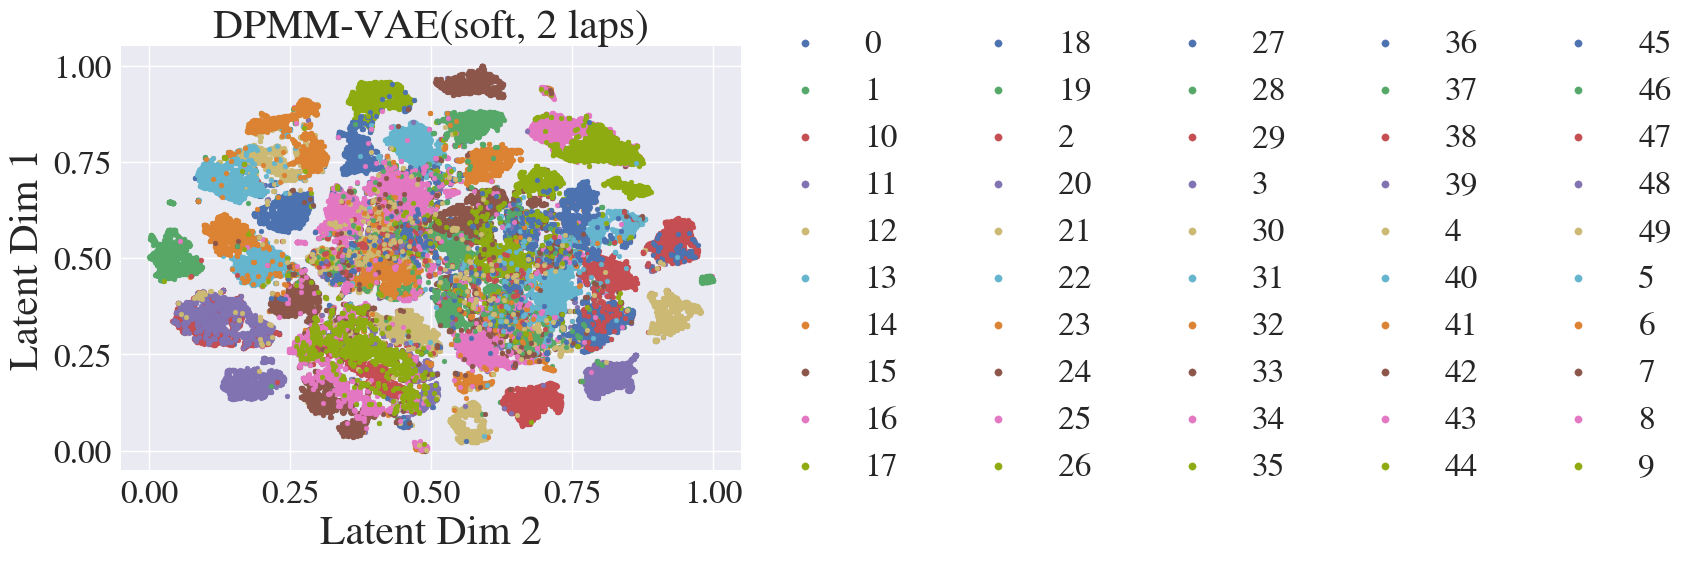

In [18]:
# fig, axs = plt.subplots(1, 2)
fig = plt.figure()
axs = fig.add_subplot(1,1,1)
axs = axs if type(axs) is np.ndarray else [axs]
legend_elements = []

for i, target_class in enumerate(df['True Label'].unique()):
  df_i = df[df['True Label']==target_class]
  el = axs[0].scatter(df_i['0'], df_i['1'], 
            label=target_class,
            marker='.',
            color=colors[i % len(colors)])
  legend_elements.append(el)
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.5), markerscale=1.5, ncol=5)
axs[0].set_ylabel('Latent Dim 1')
axs[0].set_xlabel('Latent Dim 2')
axs[0].set_title('DIVA-ImageNet50 Example plot')
fig.show()
fig.savefig('save/imgs/latent_space.pdf',bbox_inches='tight')
